In [ ]:
pip install catboost

     |████████████████████████████████| 65.9MB 44kB/s 


In [ ]:
#imports
import pandas as pd
import numpy as np
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
import numpy as np
import sklearn 
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [ ]:
df_train = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')

In [ ]:
#removing rows with 0 values in tumor size
df_train = df_train[df_train['tumor_size']!=0]

Feature engineering

In [ ]:
df_train['total_estimated_samples'] =  (df_train['err_malign'] / df_train['std_dev_malign'])  
df_train['size_ratio_interaction'] = df_train['damage_size'] * df_train['damage_ratio']
df_train['damaged_area'] = df_train['size_npear'] / df_train['damage_size']
df_train['sorted_interaction'] = df_train['malign_penalty'] * df_train['damage_ratio']
df_train['exposed_are_per_unit_mass'] = df_train['exposed_area'] / df_train['mass_npea']
df_train['feat_1'] = df_train['malign_penalty'] * df_train['mass_npea']
df_train['tumor_area'] = df_train['exposed_area'] - df_train['damage_size']
df_train['skin_spread'] = df_train['tumor_area'] / df_train['damage_ratio']
df_train['tumor_mass'] = df_train['tumor_area'] * df_train['mass_npea'] / df_train['size_npear']
df_train["Malign_skin_size"] = (np.log(df_train["size_npear"])/(df_train["malign_ratio"]+1))+df_train["std_dev_malign"]-(df_train["err_malign"]/(df_train["malign_penalty"]+1))                                  
df_train['sum_of_values_minus_mean'] = df_train['std_dev_malign']  * df_train['err_malign']
df_train['variance'] = np.sqrt(df_train['std_dev_malign'] )


#test
df_test['total_estimated_samples'] =   df_test['err_malign'] / df_test['std_dev_malign'] 
df_test['size_ratio_interaction'] = df_test['damage_size'] * df_test['damage_ratio']
df_test['damaged_area'] = df_test['size_npear'] / df_test['damage_size']
df_test['sorted_interaction'] = df_test['malign_penalty'] * df_test['damage_ratio']
df_test['exposed_are_per_unit_mass'] = df_test['exposed_area'] / df_test['mass_npea']
df_test['feat_1'] = df_test['malign_penalty'] * df_test['mass_npea']
df_test['tumor_area'] = df_test['exposed_area'] - df_test['damage_size']
df_test['skin_spread'] = df_test['tumor_area'] / df_test['damage_ratio']
df_test['tumor_mass'] = df_test['tumor_area'] * df_test['mass_npea'] / df_test['size_npear']
df_test["Malign_skin_size"] = (np.log(df_test["size_npear"])/(df_test["malign_ratio"]+1))+df_test["std_dev_malign"]-(df_test["err_malign"]/(df_test["malign_penalty"]+1))
df_test['sum_of_values_minus_mean'] = df_test['std_dev_malign']  * df_test['err_malign']
df_test['variance'] = np.sqrt(df_test['std_dev_malign'] )

In [ ]:

 
X_train, Y = df_train.drop(['malign_ratio','exposed_area',"tumor_size"], axis=1).values, df_train["tumor_size"].values
X_test = df_test.drop(['malign_ratio','exposed_area'], axis=1).values

In [ ]:
kfold, scores = KFold(n_splits=5, shuffle=True, random_state=0), list()
for training, testing in kfold.split(X_train):
    x_train, x_test = X_train[training], X_train[testing]
    y_train, y_test = Y[training], Y[testing]
    model = CatBoostRegressor( random_state=27,n_estimators=4000,task_type="GPU",devices="0:1",boosting_type="Plain",
                              verbose=500,max_depth=13,learning_rate=0.09)
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    for i in range(len(preds)):
      if preds[i]<0:
        preds[i] = 0

    score = np.sqrt(sklearn.metrics.mean_squared_error(y_test, preds))
    scores.append(score)
    print(score)
print("Average: ", sum(scores)/len(scores))

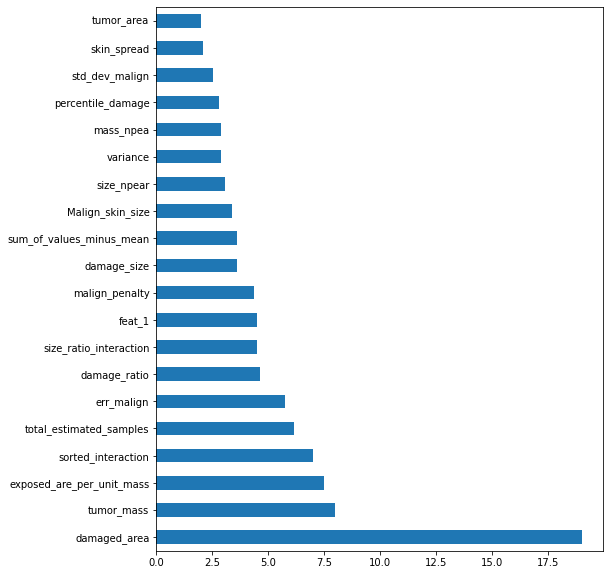

In [ ]:
feat_imp = pd.Series(model.feature_importances_, index=df_train.drop(['malign_ratio','exposed_area',"tumor_size"], axis=1).columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

In [ ]:
i=0
setused=X_train
targ=Y

scores=[]
splits=15

cnf_matrix=[]
oof_preds = np.zeros((len(X_test)))
kfold, scores = KFold(n_splits=splits,random_state=True), list()
for train2, test2 in kfold.split(setused,targ):
    x_train, x_test = setused[train2], setused[test2]
    y_train, y_test = targ[train2], targ[test2]
    eval_set = [(x_test,y_test)]
    model = CatBoostRegressor( random_state=27,n_estimators=4000,task_type="GPU",devices="0:1",boosting_type="Plain",
                              verbose=500,max_depth=13,learning_rate=0.09)

    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    score = np.sqrt(sklearn.metrics.mean_squared_error(y_test, preds))
    scores.append(score)
    print(score)
    oof_preds += model.predict(X_test)
oof_preds = oof_preds/splits

print("Average: ", np.sum(scores)/len(scores))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0:	learn: 5.8765020	total: 67.7ms	remaining: 4m 30s
500:	learn: 0.9697585	total: 15.7s	remaining: 1m 49s
1000:	learn: 0.4171791	total: 31s	remaining: 1m 32s
1500:	learn: 0.2248679	total: 46.4s	remaining: 1m 17s
2000:	learn: 0.1475683	total: 1m 1s	remaining: 1m 1s
2500:	learn: 0.1075849	total: 1m 17s	remaining: 46.4s
3000:	learn: 0.0930660	total: 1m 32s	remaining: 30.9s
3500:	learn: 0.0859986	total: 1m 48s	remaining: 15.5s
3999:	learn: 0.0835664	total: 2m 4s	remaining: 0us
3.458426859567924
0:	learn: 5.8748075	total: 68.2ms	remaining: 4m 32s
500:	learn: 0.9634021	total: 16.3s	remaining: 1m 53s
1000:	learn: 0.4517803	total: 32.3s	remaining: 1m 36s
1500:	learn: 0.2366471	total: 48.3s	remaining: 1m 20s
2000:	learn: 0.1574900	total: 1m 4s	remaining: 1m 4s
2500:	learn: 0.1121495	total: 1m 20s	remaining: 48.2s
3000:	learn: 0.0947931	total: 1m 36s	remaining: 32.1s
3500:	learn: 0.0872461	total: 1m 52s	remaining: 16s
3999:	learn: 0.0840423	total: 2m 7s	remaining: 0us
3.5951476416465296
0:	learn:

In [ ]:
#post processing
#copying duplicate values from train to test

preds = oof_preds
for i in range(len(preds)):
  if preds[i]<0:
    preds[i] = 0

df_train['key'] = df_train['mass_npea'].astype(str) + "_" + df_train['size_npear'].astype(str) + "_" + df_train['malign_ratio'].astype(str)
df_test['key'] = df_test['mass_npea'].astype(str) + "_" + df_test['size_npear'].astype(str) + "_" + df_test['malign_ratio'].astype(str)

map_key ={}

key = df_train['key'].values
tumor = df_train['tumor_size'].values

for i in range(len(key)):
  map_key[key[i]] = tumor[i]

key = df_test['key'].values

for i in range(len(key)):
  if key[i] in map_key:
    preds[i] = map_key[key[i]]


df_submit = pd.DataFrame({'tumor_size': preds})
df_submit.to_excel("submit_cb_oof.xlsx", index=False)
